In [2]:
dut.reset_chip()
dut.reset_dpe()
dut.ground_PIC()
dut.power_on()

DAC initialized to a span from -5 V to 5 V


In [165]:
dut.disconnect()

Serial port disconnected.


In [1]:
%reload_ext autoreload
%autoreload 2

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=1)
dut.connect(ser)

Test with a IV sweep

5.00-

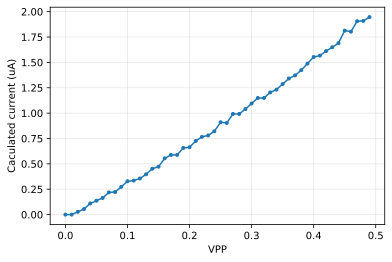

In [3]:
ar=2
r=31
c=0

Vreads = np.arange(0, 0.5, 0.01)
# Vgates = np.arange(0,5,0.5)
# Vgates = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 5]
Vgates = [5]

volts_set = []

for Vgate in Vgates:
    print(f'{Vgate:.2f}', end='-')
    volts = []
    for vread in Vreads:
        volts.append( a0.read_single(vread, Vgate, array=ar, row=r, col=c, gain=4) )
    volts_set.append(volts)
    
for volts in volts_set:
    plt.plot(Vreads, [i* 1e6 for i in volts], '.-')
    
plt.xlabel('VPP')
plt.ylabel('Caculated current (uA)')
plt.grid(True, alpha=0.3)
# plt.ylim(-0.1, 6)

Batch read domo

Reading array0
Reading array1
Reading array2
2.1580190658569336


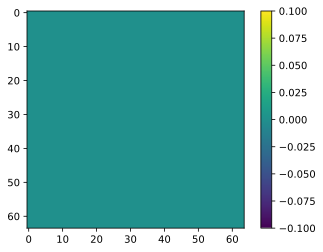

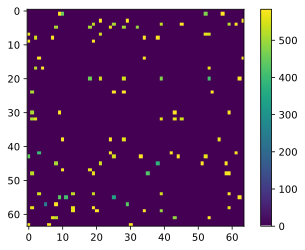

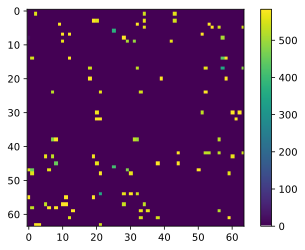

In [20]:
ts = time.time()
Vr = 0.2
Gmaps = []

for arr in range(3):
    print('Reading array' + str(arr))
    Gmaps.append( a0.pic_read_batch(arr, Vread=Vr, gain=2) / Vr )
print(time.time()-ts)

for i in range(3):
    plt.figure(i)
    plt.imshow(Gmaps[i] * 1e6)
    plt.colorbar()

DPE read with unselected rows grounded

DPE: 0-60, len=60
DPE: 60-64, len=4
0.052997589111328125


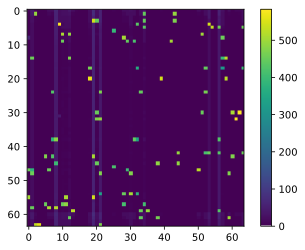

In [23]:
input = [0x1<<i for i in range(64)]
ts = time.time()
data = a0.pic_dpe_batch(2, input, gain=2, Vread=0.2, mode=0) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()

DPE read with unselected rows floar

DPE: 0-60, len=60
DPE: 60-64, len=4
0.05501699447631836


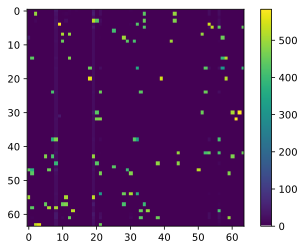

In [24]:
input = [0x1<<i for i in range(64)]
ts = time.time()
data = a0.pic_dpe_batch(2, input, gain=2, Vread=0.2, mode=1) / 0.2
print(time.time()-ts)

plt.imshow(data * 1e6)
plt.colorbar()